<a href="https://colab.research.google.com/github/Eman0879/Chronos_Forcasting/blob/main/Chronos2_Forcasting(Univariate%26Covariates).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install 'chronos-forecasting>=2.0' 'pandas[pyarrow]' 'matplotlib'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 140.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [ ]:

# Load data as a long-format pandas data frame
data = pd.read_csv('/content/energy_dataset.csv')
print(data.columns)

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')


Univariate forecasting is performed to predict future hourly energy demand using historical energy load data and corresponding time information from previous hours and days.

In [ ]:
# Select only the relevant columns
data = data[['time', 'total load actual']]

# Rename them to match Chronos expected input format
data = data.rename(columns={'time': 'timestamp', 'total load actual': 'target'})

# Convert timestamp to datetime and sort chronologically
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values('timestamp')
data["timestamp"] = pd.to_datetime(data["timestamp"], utc=True)

display(data.head())

/tmp/ipython-input-3306938372.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['timestamp'] = pd.to_datetime(data['timestamp'])


,timestamp,target
0,2014-12-31 23:00:00+00:00,25385.0
1,2015-01-01 00:00:00+00:00,24382.0
2,2015-01-01 01:00:00+00:00,22734.0
3,2015-01-01 02:00:00+00:00,21286.0
4,2015-01-01 03:00:00+00:00,20264.0


In [ ]:
# Energy price forecasting configuration
target = "target"  # Column name containing the values to forecast (energy prices)
prediction_length = 30  # Number of hours to forecast ahead
id_column = "item_id"  # Column identifying different time series (countries/regions)
timestamp_column = "timestamp"  # Column containing datetime information
timeseries_id = "DE"  # Specific time series to visualize (Germany)

data["item_id"] = "energy_load"

train_data = data.iloc[:-30]
test_data = data.iloc[-30:]

forecast_uni = pipeline.predict_df(
train_data,
future_df= None,
prediction_length=30,
quantile_levels=[0.1, 0.5, 0.9],
id_column=id_column,
timestamp_column=timestamp_column,
target=target,
)

print("Output dataframe shape:", forecast_uni.shape)
display(forecast_uni.head())

Output dataframe shape: (30, 7)


,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,energy_load,2018-12-30 17:00:00+00:00,target,27672.638672,27363.414062,27672.638672,28084.531250
1,energy_load,2018-12-30 18:00:00+00:00,target,28865.462891,28537.900391,28865.462891,29383.333984
2,energy_load,2018-12-30 19:00:00+00:00,target,29601.873047,29156.169922,29601.873047,30151.716797
3,energy_load,2018-12-30 20:00:00+00:00,target,29748.013672,29240.250000,29748.013672,30328.449219
4,energy_load,2018-12-30 21:00:00+00:00,target,28631.201172,28183.984375,28631.201172,29146.697266


Code For Visualization

In [ ]:

# Visualization helper function
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "item_id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(timestamp_column )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_data.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()


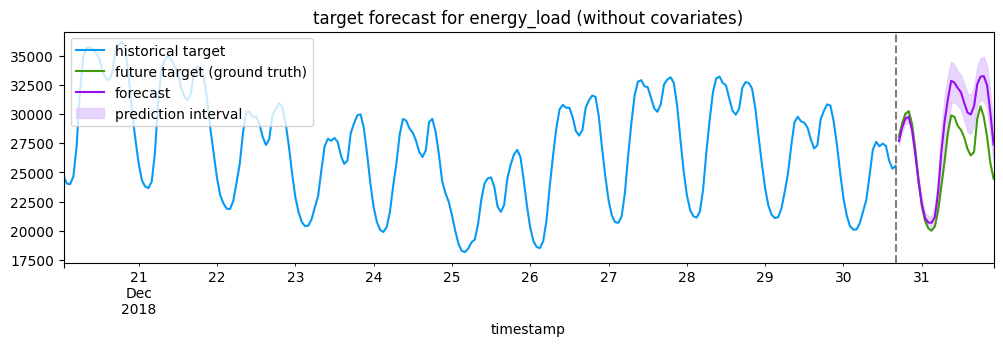

In [ ]:
plot_forecast(
    train_data,
    forecast_uni,
    test_data,
    target_column=target,
    timeseries_id= "energy_load",
    title_suffix="(without covariates)",
)

When we use the univariate forecasting we can see that the future energy demand values deviate from the original ones that we skipped during the training process.

Forcasting with Covariates


Finding correlation of features with the target to select the highly correlated ones for our covariate forcasting.

In [ ]:
data = pd.read_csv('/content/energy_dataset.csv')

corr = data.corr(numeric_only=True)
print(corr["total load actual"].sort_values(ascending=False))



total load actual                              1.000000
total load forecast                            0.995139
generation fossil gas                          0.548913
generation fossil oil                          0.497089
generation hydro water reservoir               0.479481
price day ahead                                0.473869
price actual                                   0.436127
forecast solar day ahead                       0.404362
generation fossil hard coal                    0.396564
generation solar                               0.396189
generation fossil brown coal/lignite           0.280461
generation other renewable                     0.181714
generation hydro run-of-river and poundage     0.118570
generation other                               0.100690
generation nuclear                             0.085664
generation biomass                             0.083288
generation waste                               0.077312
generation wind onshore                        0

In [ ]:
data["timestamp"] = pd.to_datetime(data["time"], utc=True)
data["item_id"] = "energy_load"

target_col = "total load actual"
data = data.rename(columns={target_col: "target"})

covariate_cols = [
    "total load forecast",
    "price day ahead",
    "price actual",
    "generation fossil gas",
    "generation fossil oil",
    "generation fossil hard coal",
    "generation solar",
    "generation hydro water reservoir",
    "generation hydro pumped storage consumption"
]

# Keep only necessary columns and drop missing values
df = data[["timestamp", "item_id", "target"] + covariate_cols].dropna()




In [ ]:

# data preprocessing (removing duplicates, filling missing timestamp, interpolate for NaNs, adding item_id as identifier)
df = df.sort_values("timestamp").drop_duplicates(subset=["timestamp"])
full_index = pd.date_range(start=df["timestamp"].min(), end=df["timestamp"].max(), freq="h", tz="UTC")
df = pd.merge(pd.DataFrame({"timestamp": full_index}), df, on="timestamp", how="left")
df = df.interpolate()
df["item_id"] = "energy_load"

# Confirm frequency
print("Inferred frequency:", pd.infer_freq(df["timestamp"]))

Inferred frequency: h


/tmp/ipython-input-475260710.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


In [ ]:
train_data = df.iloc[:-30]
test_data = df.iloc[-30:]

future_df = test_data.drop(columns="target")

display(train_data.head())
display(future_df.head())


,timestamp,item_id,target,total load forecast,price day ahead,price actual,generation fossil gas,generation fossil oil,generation fossil hard coal,generation solar,generation hydro water reservoir,generation hydro pumped storage consumption
0,2014-12-31 23:00:00+00:00,energy_load,25385.0,26118.0,50.10,65.41,4844.0,162.0,4821.0,49.0,1899.0,863.0
1,2015-01-01 00:00:00+00:00,energy_load,24382.0,24934.0,48.10,64.92,5196.0,158.0,4755.0,50.0,1658.0,920.0
2,2015-01-01 01:00:00+00:00,energy_load,22734.0,23515.0,47.33,64.48,4857.0,157.0,4581.0,50.0,1371.0,1164.0
3,2015-01-01 02:00:00+00:00,energy_load,21286.0,22642.0,42.27,59.32,4314.0,160.0,4131.0,50.0,779.0,1503.0
4,2015-01-01 03:00:00+00:00,energy_load,20264.0,21785.0,38.41,56.04,4130.0,156.0,3840.0,42.0,720.0,1826.0


,timestamp,item_id,total load forecast,price day ahead,price actual,generation fossil gas,generation fossil oil,generation fossil hard coal,generation solar,generation hydro water reservoir,generation hydro pumped storage consumption
35034,2018-12-30 17:00:00+00:00,energy_load,28161.0,65.51,71.43,5442.0,229.0,1456.0,200.0,3279.0,1.0
35035,2018-12-30 18:00:00+00:00,energy_load,29201.0,67.02,72.37,5730.0,228.0,1510.0,31.0,3422.0,1.0
35036,2018-12-30 19:00:00+00:00,energy_load,30140.0,67.83,73.35,5683.0,221.0,1556.0,31.0,3501.0,1.0
35037,2018-12-30 20:00:00+00:00,energy_load,30378.0,68.40,73.64,5859.0,216.0,1616.0,31.0,4248.0,1.0
35038,2018-12-30 21:00:00+00:00,energy_load,29418.0,67.64,71.92,5660.0,215.0,1610.0,31.0,3757.0,1.0


In [ ]:

forecast_cov_df = pipeline.predict_df(
    train_data,
    future_df= future_df,
    prediction_length=30,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column= id_column,
    timestamp_column= timestamp_column,
    target= target
)

display(forecast_cov_df.head())


,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,energy_load,2018-12-30 17:00:00+00:00,target,27886.964844,27549.656250,27886.964844,28334.535156
1,energy_load,2018-12-30 18:00:00+00:00,target,29065.880859,28682.275391,29065.880859,29526.554688
2,energy_load,2018-12-30 19:00:00+00:00,target,29872.773438,29480.169922,29872.773438,30319.640625
3,energy_load,2018-12-30 20:00:00+00:00,target,30029.285156,29587.050781,30029.285156,30486.437500
4,energy_load,2018-12-30 21:00:00+00:00,target,28973.244141,28594.017578,28973.244141,29342.078125


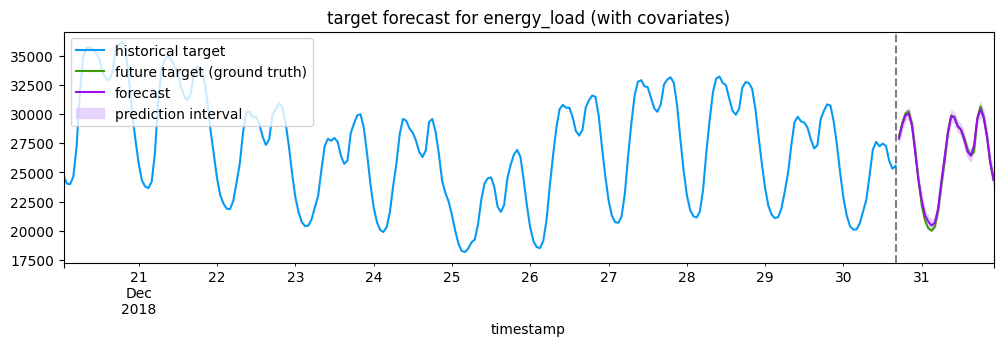

In [ ]:
# Visualize forecast with covariates
plot_forecast(
    train_data,
    forecast_cov_df,
    test_data,
    target_column= target,
    timeseries_id= "energy_load",
    title_suffix="(with covariates)",
)

When we use covariates forcasting we see that the prediction of future energy demand is very accurate to the actual values that we skipped for the training process.
